In [95]:
# Olist Customer Churn Prediction - Simplified Model Comparison with Cleaner LightGBM + Feature Names Fix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
import seaborn as sns

# Load datasets
orders = pd.read_csv('../data/olist_orders_dataset.csv')
customers = pd.read_csv('../data/olist_customers_dataset.csv')
payments = pd.read_csv('../data/olist_order_payments_dataset.csv')
reviews = pd.read_csv('../data/olist_order_reviews_dataset.csv')
products = pd.read_csv('../data/olist_products_dataset.csv')
order_items = pd.read_csv('../data/olist_order_items_dataset.csv')

# Merge datasets
orders = pd.merge(orders, customers, on='customer_id', how='left')
orders = pd.merge(orders, payments.groupby('order_id').payment_value.sum().reset_index(), on='order_id', how='left')
orders = pd.merge(orders, reviews.groupby('order_id').review_score.mean().reset_index(), on='order_id', how='left')
order_items = pd.merge(order_items, products[['product_id', 'product_category_name']], on='product_id', how='left')
order_items = pd.merge(order_items, orders[['order_id', 'customer_unique_id']], on='order_id', how='left')
product_diversity = order_items.groupby('customer_unique_id')['product_category_name'].nunique().reset_index().rename(columns={'product_category_name': 'product_diversity'})

features = orders.groupby('customer_unique_id').agg(
    n_orders=('order_id', 'count'),
    total_payment=('payment_value', 'sum'),
    avg_review_score=('review_score', 'mean')
).reset_index()
features = pd.merge(features, product_diversity, on='customer_unique_id', how='left')

# Churn definition
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
cutoff_date = orders['order_purchase_timestamp'].max() - pd.DateOffset(months=6)
last_order = orders.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
features = pd.merge(features, last_order, on='customer_unique_id', how='left')
features['churn'] = (features['order_purchase_timestamp'] < cutoff_date).astype(int)

# Impute + missing indicators
X_base = features.drop(columns=['customer_unique_id', 'churn', 'order_purchase_timestamp'])

missing_indicators = X_base.isna().astype(int)
missing_indicators.columns = [col + '_missing' for col in missing_indicators.columns]
X_imputed = pd.DataFrame(SimpleImputer(strategy='median').fit_transform(X_base), columns=X_base.columns)
X = pd.concat([X_imputed, pd.DataFrame(missing_indicators.values, columns=missing_indicators.columns)], axis=1)
y = features['churn']



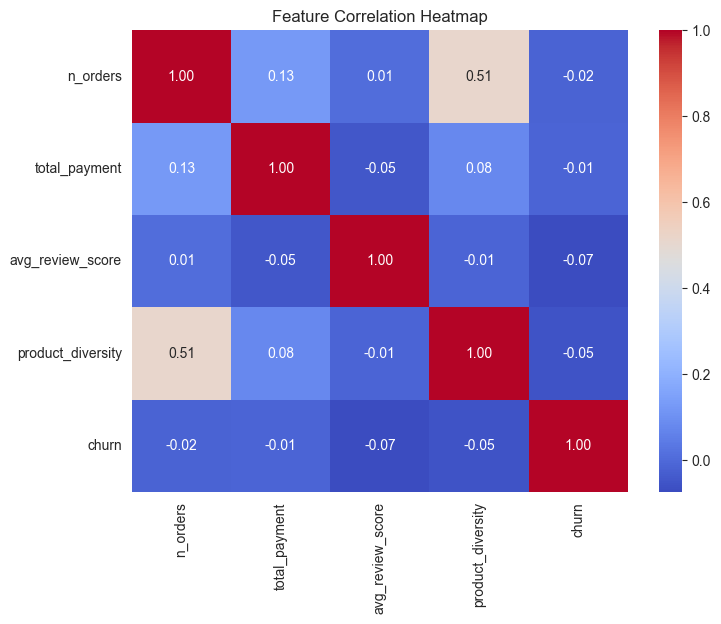

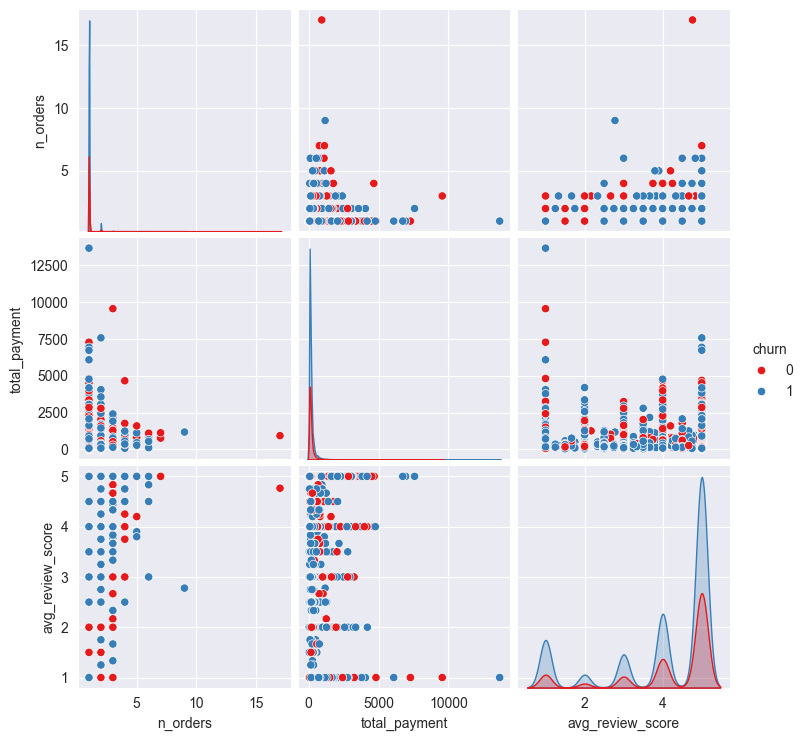

In [96]:
# Correlation heatmap of features

plt.figure(figsize=(8,6))
sns.heatmap(pd.concat([X_base, y], axis=1).corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Pairplot of key features
sns.pairplot(pd.concat([X_base[['n_orders', 'total_payment', 'avg_review_score']], y], axis=1), hue='churn', palette='Set1')
plt.show()

XGBoost ROC AUC: 0.5926
              precision    recall  f1-score   support

           0       0.35      0.62      0.44      5703
           1       0.76      0.51      0.61     13517

    accuracy                           0.54     19220
   macro avg       0.55      0.56      0.53     19220
weighted avg       0.64      0.54      0.56     19220

[LightGBM] [Info] Number of positive: 54063, number of negative: 22813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 76876, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
LightGBM ROC AUC: 0.5897
              precision    recall  f1-score   support

           0 

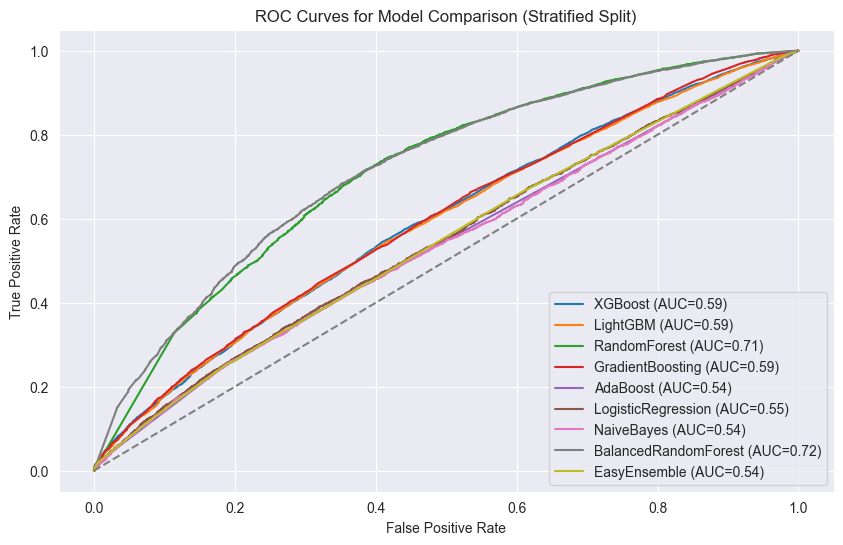

In [97]:



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

models = {
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()),
    'LightGBM': LGBMClassifier(random_state=42, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'NaiveBayes': GaussianNB(),
    'BalancedRandomForest': BalancedRandomForestClassifier(random_state=42),
    'EasyEnsemble': EasyEnsembleClassifier(random_state=42)
}

plt.figure(figsize=(10,6))
for name, model in models.items():
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"{name} ROC AUC: {roc_auc:.4f}")
    print(classification_report(y_test, model.predict(X_test), zero_division=0))
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Model Comparison (Stratified Split)')
plt.legend()
plt.grid(True)
plt.show()
